# Data Pipeline

**Contents**
1. Load simulated datasets from `/data`.
2. Apply initial filtering by doing hard cuts by doing Manual filtering/ hard cuts. This will be done on all the datasets, including the simulated acceptance.
3. Train Machine Learning model(s) on the partially filtered datasets
4. Classify and filter the `total_dataset` and `acceptance_mc` based on predictions from the model
5. Off to Fitting group!

---

# 1. Load Data

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
%config InlineBackend.figure_formats = ['svg']

Load total and acceptance datasets

In [3]:
total = pd.read_pickle('data/total_dataset.pkl')
acc = pd.read_pickle('data/acceptance_mc.pkl')

Load simulated datasets and append to one another to create long dataframe with class label. In this case we are doing **binary classification** so the two classes are `signal` and `other`.

In [7]:
simulations = ['jpsi_mu_k_swap','psi2S','jpsi_mu_pi_swap', 'phimumu', 'pKmumu_piTop',
    'signal','pKmumu_piTok_kTop','k_pi_swap','jpsi']

df = pd.DataFrame()

for file in simulations:
    temp_df = pd.read_pickle('data/' + file + '.pkl')
    if file == 'signal': 
        temp_df["class"] = 'signal'
    else:
        temp_df["class"] = 'other'
    df = df.append(temp_df, ignore_index=True)

sim = df


# 2. Manual Cuts

In [1]:
from FilterPy import q2_cuts

## Cut on the total dataset, acceptance and simulated

In [28]:
datasets = [total, acc, sim]

total = q2_cuts(total)
acc = q2_cuts(acc)
sim = q2_cuts(sim)

percentage dataframe removed = 0.8972553663358388
percentage dataframe removed = 0.3394530863112551
percentage dataframe removed = 0.799171778969561


# 3. Machine Learning

In [14]:
features = ['mu_plus_MC15TuneV1_ProbNNk', 'mu_plus_MC15TuneV1_ProbNNpi',
       'mu_plus_MC15TuneV1_ProbNNmu', 'mu_plus_MC15TuneV1_ProbNNe',
       'mu_plus_MC15TuneV1_ProbNNp', 'mu_plus_P', 'mu_plus_PT', 'mu_plus_ETA',
       'mu_plus_PHI', 'mu_plus_PE', 'mu_plus_PX', 'mu_plus_PY', 'mu_plus_PZ',
       'mu_plus_IPCHI2_OWNPV', 
       'mu_minus_MC15TuneV1_ProbNNk', 'mu_minus_MC15TuneV1_ProbNNpi', 'mu_minus_MC15TuneV1_ProbNNmu',
       'mu_minus_MC15TuneV1_ProbNNe', 'mu_minus_MC15TuneV1_ProbNNp',
       'mu_minus_P', 'mu_minus_PT', 'mu_minus_ETA', 'mu_minus_PHI',
       'mu_minus_PE', 'mu_minus_PX', 'mu_minus_PY', 'mu_minus_PZ',
       'mu_minus_IPCHI2_OWNPV', 
       'K_MC15TuneV1_ProbNNk', 'K_MC15TuneV1_ProbNNpi', 'K_MC15TuneV1_ProbNNmu',
       'K_MC15TuneV1_ProbNNe', 'K_MC15TuneV1_ProbNNp', 'K_P', 'K_PT', 'K_ETA',
       'K_PHI', 'K_PE', 'K_PX', 'K_PY', 'K_PZ', 'K_IPCHI2_OWNPV',
       'Pi_MC15TuneV1_ProbNNk', 'Pi_MC15TuneV1_ProbNNpi',
       'Pi_MC15TuneV1_ProbNNmu', 'Pi_MC15TuneV1_ProbNNe',
       'Pi_MC15TuneV1_ProbNNp', 'Pi_P', 'Pi_PT', 'Pi_ETA', 'Pi_PHI', 'Pi_PE',
       'Pi_PX', 'Pi_PY', 'Pi_PZ', 'Pi_IPCHI2_OWNPV', 
       'B0_MM', 'B0_ENDVERTEX_CHI2', 'B0_ENDVERTEX_NDOF', 'B0_FDCHI2_OWNPV', 
       'Kstar_MM', 'Kstar_ENDVERTEX_CHI2', 'Kstar_ENDVERTEX_NDOF', 'Kstar_FDCHI2_OWNPV',
       'J_psi_MM', 'J_psi_ENDVERTEX_CHI2', 'J_psi_ENDVERTEX_NDOF',
       'J_psi_FDCHI2_OWNPV', 
       'B0_IPCHI2_OWNPV', 'B0_DIRA_OWNPV', 'B0_OWNPV_X',
       'B0_OWNPV_Y', 'B0_OWNPV_Z', 'B0_FD_OWNPV', 'B0_ID', 'q2']

In [11]:
# Import machine learning models
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

## 3.1 Training

In [32]:
# Feature dataset
X = sim[features]
# Labels/ class dataset
y = sim.iloc[:, -1]

# Test train split, in a stratified manner
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=20, stratify = y)

In [33]:
forest = RandomForestClassifier(verbose=1, n_jobs = 4)
forest.fit(X_train, y_train)
pickle.dump(forest, open('saved_models/rf.pkl', 'wb'))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   24.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   58.0s finished


## 3.2 Validation

In [34]:
y_valid_pred = forest.predict(X_valid)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


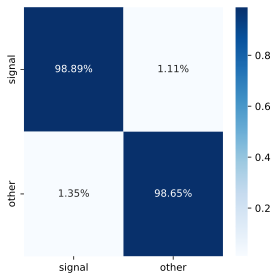

In [35]:
from sklearn.metrics import confusion_matrix 
cm_forest = confusion_matrix(y_valid, y_valid_pred, labels = ['signal', 'other'])

plt.figure(figsize=(4,4))
sns.heatmap(cm_forest/cm_forest.sum(keepdims=True, axis=1), annot=True, 
            fmt='.2%', cmap='Blues', xticklabels=['signal', 'other'], yticklabels=['signal', 'other'])

plt.tight_layout()

# 4. Classification

In [36]:
def gen_predictions(df, cols_to_use, model):
    """Drops rows based on its class, which is inferred 
    by Classifying through a Machine Learning model

    Args:
        df (pd.DataFrame): _description_
        cols_to_use (_type_): _description_
        model (sklearn.model): _description_

    Returns:
        filtered (pd.DataFrame): _description_
    """
    X = df[cols_to_use]
    y_predict = model.predict(X)
    df['predictions'] = y_predict
    
    filtered = df[df['predictions'] == 'signal']
    
    print('Percentage of data kept:', len(filtered)/len(df) *100)
    return filtered

In [37]:
filtered = gen_predictions(total, features, forest)
acc_filtered = gen_predictions(acc, features, forest)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


Percentage of data kept: 33.495468041881544


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.5s finished


Percentage of data kept: 98.88346613335473


In [38]:
filtered

,mu_plus_MC15TuneV1_ProbNNk,mu_plus_MC15TuneV1_ProbNNpi,mu_plus_MC15TuneV1_ProbNNmu,mu_plus_MC15TuneV1_ProbNNe,mu_plus_MC15TuneV1_ProbNNp,mu_plus_P,mu_plus_PT,mu_plus_ETA,mu_plus_PHI,mu_plus_PE,...,B0_OWNPV_Z,B0_FD_OWNPV,B0_ID,q2,phi,costhetal,costhetak,polarity,year,predictions
0,0.000303,0.282979,0.966269,2.708744e-06,0.000024,22529.217656,3371.873364,2.586844,-2.463601,22529.465415,...,103.8536,2.377813,-511,3.627847,0.687398,-0.467658,0.992306,1,2016,signal
47,0.066464,0.018787,0.971390,6.903303e-05,0.000109,61231.670000,11040.241297,2.398037,-1.672196,61231.761159,...,3.2579,9.005466,-511,0.230524,2.046090,0.654761,0.242833,1,2016,signal
60,0.203241,0.045158,0.869359,3.173170e-05,0.006525,36799.901558,3921.238876,2.929384,0.093912,36800.053239,...,19.7726,1.261941,-511,0.187777,1.246246,0.091872,0.980592,1,2016,signal
69,0.001714,0.025349,0.999226,3.061438e-06,0.000001,75360.360000,4612.170375,3.485792,-2.658462,75360.434069,...,-92.6860,43.701860,-511,3.503484,2.013744,0.133503,-0.553244,1,2016,signal
131,0.020201,0.056912,0.747109,3.464552e-06,0.000955,100169.174641,7874.497955,3.234830,-3.085993,100169.230365,...,39.7444,7.883754,511,7.258556,-1.617418,0.385498,0.041972,1,2016,signal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498103,0.006847,0.725833,0.943284,3.724671e-07,0.009086,11448.392221,2280.142604,2.296691,-0.223203,11448.879776,...,-25.1955,4.296648,-511,5.419381,-0.484069,0.568855,0.656548,1,2016,signal
498139,0.000149,0.088061,0.982341,5.396297e-06,0.000011,33335.211381,1641.931866,3.703281,-1.058012,33335.378827,...,-10.8581,7.878751,511,18.693213,3.101144,-0.261523,-0.072778,1,2016,signal
498185,0.004692,0.236060,0.918846,4.531777e-06,0.004558,13387.690697,1715.373060,2.743722,2.044927,13388.107630,...,61.2067,3.040936,511,16.396301,0.450800,-0.904871,-0.597481,1,2016,signal
498220,0.018554,0.293047,0.972580,4.967262e-06,0.002174,84896.264491,3736.686348,3.815893,2.747520,84896.330240,...,-15.4294,16.596584,-511,17.804837,2.257362,0.960736,-0.005611,1,2016,signal


In [23]:
total

,mu_plus_MC15TuneV1_ProbNNk,mu_plus_MC15TuneV1_ProbNNpi,mu_plus_MC15TuneV1_ProbNNmu,mu_plus_MC15TuneV1_ProbNNe,mu_plus_MC15TuneV1_ProbNNp,mu_plus_P,mu_plus_PT,mu_plus_ETA,mu_plus_PHI,mu_plus_PE,...,B0_OWNPV_Z,B0_FD_OWNPV,B0_ID,q2,phi,costhetal,costhetak,polarity,year,predictions
0,0.000303,0.282979,0.966269,2.708744e-06,2.358479e-05,22529.217656,3371.873364,2.586844,-2.463601,22529.465415,...,103.8536,2.377813,-511,3.627847,0.687398,-0.467658,0.992306,1,2016,signal
1,0.020258,0.003956,0.998035,8.310519e-06,2.909099e-03,161024.220000,8534.230892,3.629914,-1.540762,161024.254665,...,-32.1607,6.161559,-511,13.718153,1.989341,0.814684,0.110453,-1,2016,other
2,0.088214,0.007898,0.998085,1.014832e-05,3.530469e-03,109393.330000,5710.313234,3.645141,0.265732,109393.381025,...,40.6020,47.151129,-511,9.567142,-1.738231,0.242143,-0.598537,1,2016,other
3,0.000404,0.016088,0.990623,3.606953e-06,1.098000e-05,13815.260342,1236.546436,3.104590,1.340393,13815.664371,...,-31.5099,4.679321,-511,18.784472,-0.041052,-0.832555,-0.497081,1,2016,other
4,0.000061,0.059106,0.997773,1.061150e-06,2.045247e-06,40205.947339,2979.715433,3.293958,-0.438803,40206.086170,...,-44.0725,4.054877,511,9.541409,-0.084586,-0.006600,0.294391,1,2016,other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498240,0.040453,0.001366,0.997394,1.393092e-03,1.167161e-02,211552.172468,7447.801664,4.039390,1.877470,211552.198853,...,39.0764,10.975222,511,7.739509,-1.323554,0.598088,-0.040562,1,2016,other
498241,0.000047,0.020918,0.998482,1.134924e-05,6.563242e-07,40338.590000,2968.512043,3.301038,-2.905452,40338.728375,...,-76.8413,1.959396,511,9.534103,2.481835,0.410797,-0.204429,1,2016,other
498242,0.011117,0.139928,0.991624,8.119469e-07,2.001283e-03,59256.560000,2274.457017,3.952914,1.632646,59256.654198,...,-46.5753,19.827259,-511,13.524815,-2.516108,-0.527713,0.994013,-1,2016,other
498243,0.014127,0.357343,0.758277,5.019459e-05,4.491047e-02,22014.330000,1115.553871,3.674847,-0.069939,22014.583554,...,-63.5059,5.819832,511,13.086508,0.965240,0.033597,-0.533498,-1,2016,other


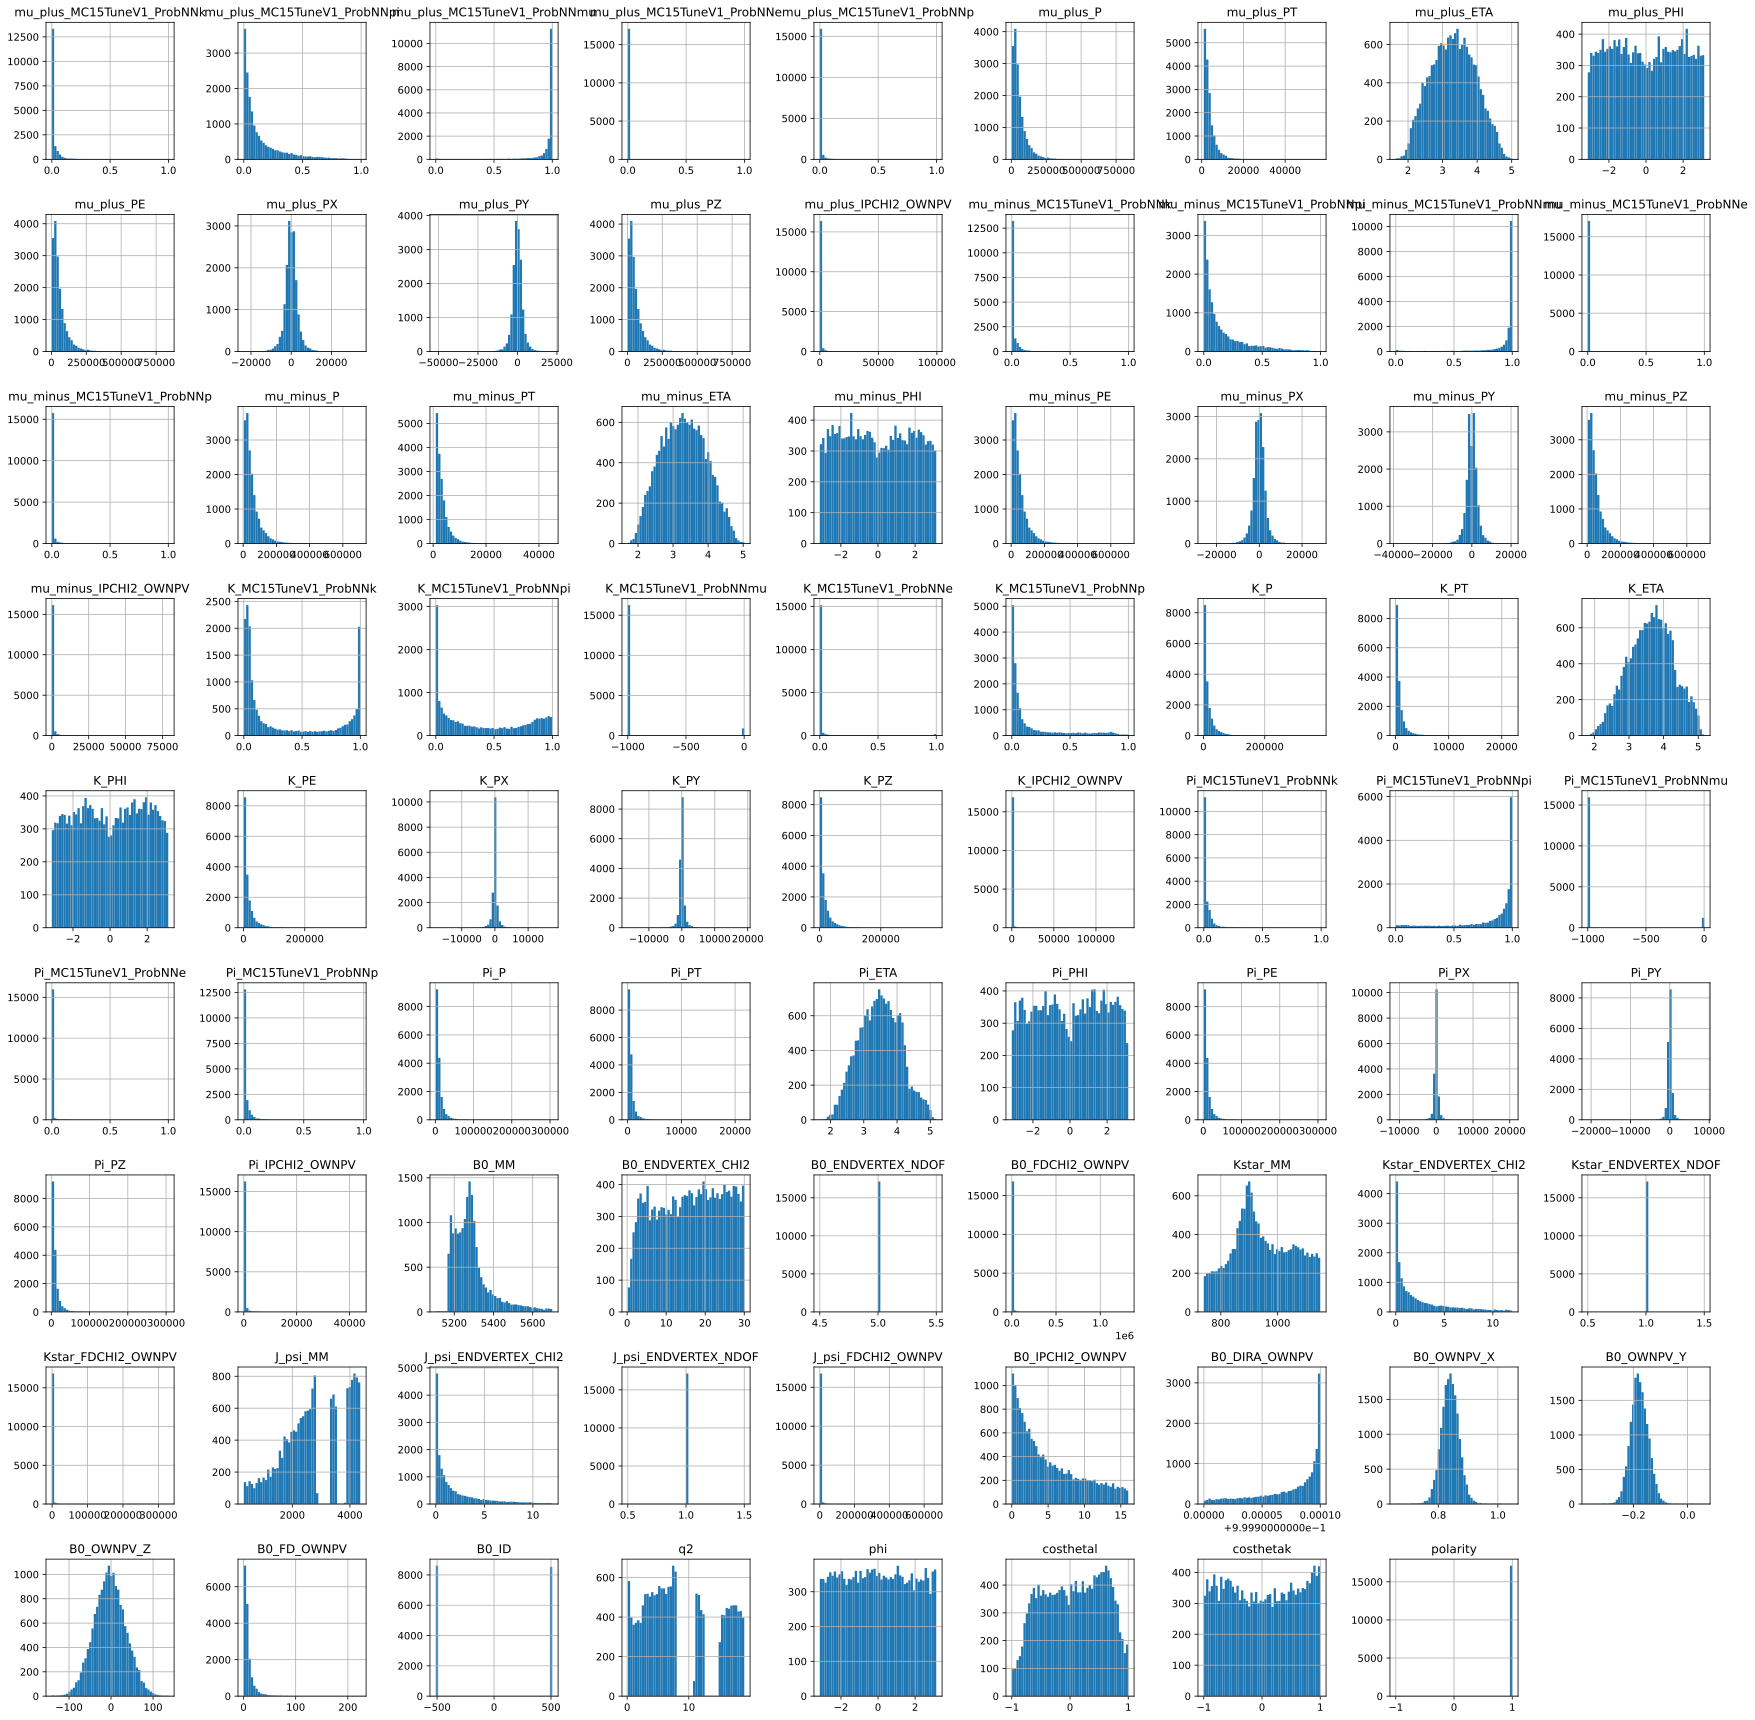

In [39]:
plt.rcParams["figure.figsize"] = (24,24)
plt.rc("figure", dpi=300)
filtered.hist(bins=50)
plt.tight_layout()
plt.show()

# 5. Send to Fitting Group